In [1]:
import matplotlib.pyplot as plt
import cv2
import re
import numpy as np
import pickle

In [2]:
def readTextFiles(path):
  f = open(path)
  captions = f.read()
  return captions

In [3]:
captions = readTextFiles("D:/study/Datasets/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

captions = captions.split("\n")[:-1]
len(captions)

40460

In [4]:
descriptions = {}

for x in captions:
    first,second = x.split("\t")
    img = first.split(".")[0]
    if descriptions.get(img) is None:
        descriptions[img] = []
        
    descriptions[img].append(second)

In [5]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

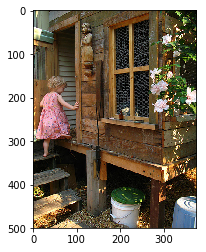

In [7]:
img_path = "D:\study\Datasets\Flickr_Data\Images\\"

img = cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = " ".join(sentence)
    return sentence

In [9]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [10]:
descriptions["1000268201_693b08cb0e"]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [11]:
vocab = set()
for key in descriptions.keys():
    for sentence in descriptions[key]:
        vocab.update(sentence.split())
        
len(vocab)

8441

In [12]:
total_words = []

for key in descriptions.keys():
    [total_words.append(word) for sentence in descriptions[key] for word in sentence.split()]
    
len(total_words)

437466

In [13]:
import collections

counter = collections.Counter(total_words)
frq_count = dict(counter)

len(frq_count.keys())

8441

In [14]:
threshhold_frq = 10
total_words = [item[0] for item in frq_count.items() if item[1] > threshhold_frq]

In [15]:
len(total_words)

1850

## Prepare Train/Test data

In [16]:
train_file_data = readTextFiles("D:\study\Datasets\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt")
test_file_data = readTextFiles("D:\study\Datasets\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt")

In [17]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [18]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [19]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for sentence in descriptions[img_id]:
        sentence_to_append = "startseq " + sentence + " endseq"
        train_descriptions[img_id].append(sentence_to_append)

In [20]:
train_descriptions["1000268201_693b08cb0e"]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

## Image preprocessing

In [21]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image

Using TensorFlow backend.


In [22]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

W0822 16:35:43.319141  8420 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 16:35:43.337094  8420 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 16:35:43.343079  8420 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0822 16:35:43.564505  8420 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
model_new = Model(model.input,model.layers[-2].output)

def preprocess_img(img_path):
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)        #Normalization
    return img

W0822 16:35:52.734972  8420 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


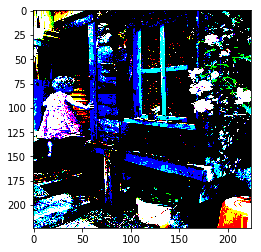

In [24]:
img = preprocess_img(img_path+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])

In [25]:
def encode_img(img_path):
    img = preprocess_img(img_path)
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [26]:
encode_img(img_path+"1000268201_693b08cb0e.jpg")

array([0.04154286, 0.17076087, 0.2927856 , ..., 0.05089605, 0.31322372,
       0.8600747 ], dtype=float32)

In [27]:
encoded_train = {}

for ix,img_id in enumerate(train):
    image_path = img_path + img_id + ".jpg"
    encoded_train[img_id] = encode_img(image_path)
    
    if ix%100 == 0 :
        print("Step :",ix)

Step : 0
Step : 100
Step : 200
Step : 300
Step : 400
Step : 500
Step : 600
Step : 700
Step : 800
Step : 900
Step : 1000
Step : 1100
Step : 1200
Step : 1300
Step : 1400
Step : 1500
Step : 1600
Step : 1700
Step : 1800
Step : 1900
Step : 2000
Step : 2100
Step : 2200
Step : 2300
Step : 2400
Step : 2500
Step : 2600
Step : 2700
Step : 2800
Step : 2900
Step : 3000
Step : 3100
Step : 3200
Step : 3300
Step : 3400
Step : 3500
Step : 3600
Step : 3700
Step : 3800
Step : 3900
Step : 4000
Step : 4100
Step : 4200
Step : 4300
Step : 4400
Step : 4500
Step : 4600
Step : 4700
Step : 4800
Step : 4900
Step : 5000
Step : 5100
Step : 5200
Step : 5300
Step : 5400
Step : 5500
Step : 5600
Step : 5700
Step : 5800
Step : 5900


In [62]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoded_train,f)

In [28]:
encoded_test = {}

for ix,img_id in enumerate(test):
    image_path = img_path + img_id + ".jpg"
    encoded_test[img_id] = encode_img(image_path)
    
    if ix%100 == 0 :
        print("Step :",ix)

Step : 0
Step : 100
Step : 200
Step : 300
Step : 400
Step : 500
Step : 600
Step : 700
Step : 800
Step : 900


In [63]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoded_test,f)

In [27]:
with open("encoded_train_features.pkl","rb") as f:
    encoded_train = pickle.load(f)

In [28]:
with open("encoded_test_features.pkl","rb") as f:
    encoded_test = pickle.load(f)

## Preprocessing captions

In [29]:
word_to_index = {}
index_to_word = {}

for i,word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [30]:
print(index_to_word[1])
print(word_to_index["dog"])

a
24


In [31]:
len(index_to_word)

1850

In [32]:
word_to_index["startseq"] = 1851
index_to_word[1851] = "startseq"

word_to_index["endseq"] = 1852
index_to_word[1852] = "endseq"

In [33]:
vocab_size = len(word_to_index) + 1
vocab_size

1853

In [34]:
max_len = 0

for key in train_descriptions.keys():
    for caption in train_descriptions[key]:
        max_len = max(max_len,len(caption.split()))
        
print(max_len)

38


## Data generator

In [35]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [36]:
def data_generator(train_descriptions,encoded_train,word_to_index,max_len,batch_size):
    X1,X2,Y = [],[],[]
    n = 0
    
    for key,desc_list in train_descriptions.items():
        n += 1
        photo = encoded_train[key]
        
        for desc in desc_list:
            seq = [word_to_index[word] for word in desc.split() if word in word_to_index]
            
            for i in range(1,len(seq)):
                xi = seq[:i]
                yi = seq[i]
                
                xi = pad_sequences([xi],value=0,padding="post",maxlen=max_len)[0]
                yi = to_categorical([yi],num_classes=vocab_size)[0]
                
                X1.append(photo)
                X2.append(xi)
                Y.append(yi)
                
        if n==batch_size:
            yield [[np.array(X1),np.array(X2)],np.array(Y)]
            X1,X2,Y = [],[],[]
            n = 0         

## Using Glove embeddings

In [37]:
embedding_index ={}

with open("D:/study/20. RNN/Emoji Predictor/dataset/glove.6B.50d.txt",encoding="utf8") as f:
    for line in f:
        values = line.split()
        embedding_index[values[0]] = np.array(values[1:],dtype='float')

In [38]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [39]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [40]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1853, 50)

## Model

In [41]:
from keras.layers import *
from keras.models import Model

In [45]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

W0821 19:31:24.186114  1352 deprecation.py:506] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0821 19:31:26.088920  1352 deprecation.py:323] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [46]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
output = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[input_img_features,input_captions],outputs=output)

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [47]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [48]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

W0821 19:31:43.120414  1352 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [42]:
from keras.models import load_model
model = load_model("model_new_weight3.h5")

W0822 16:37:54.172049  8420 deprecation.py:506] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0822 16:37:55.443290  8420 deprecation.py:323] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0822 16:37:56.370430  8420 deprecation_wrapper.py:119] From C:\Users\Hardik Kharbanda\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Training

In [43]:
epochs = 5
batch_size = 3
steps = len(train_descriptions)/batch_size

def train():
    
    for i in range(epochs):
        print("step :",i)
        generator = data_generator(train_descriptions,encoded_train,word_to_index,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save("model_weight"+str(i)+".h5")

In [44]:
train()

step : 0
Epoch 1/1
2000/2000 [==============================] - 610s 305ms/step - loss: 2.4405
step : 1
Epoch 1/1
2000/2000 [==============================] - 601s 300ms/step - loss: 2.4095
step : 2
Epoch 1/1
2000/2000 [==============================] - 599s 300ms/step - loss: 2.3837
step : 3
Epoch 1/1
2000/2000 [==============================] - 655s 328ms/step - loss: 2.3599
step : 4
Epoch 1/1
2000/2000 [==============================] - 646s 323ms/step - loss: 2.3381


## Making predictions

In [45]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_index[word] for word in in_text.split()]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]
        in_text += " "+word
        
        if word=="endseq":
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    
    return final_caption

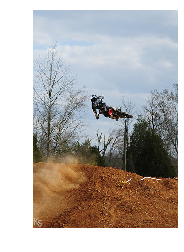

a man in a red shirt and blue helmet is riding a motorbike through the mud


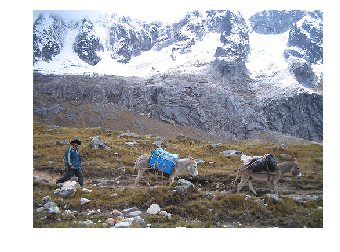

a group of people are standing on a trail in front of a city


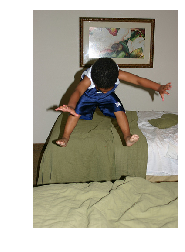

a little boy in a red shirt and blue shorts is playing with a toy


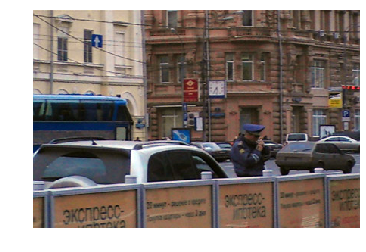

a man in a red shirt is standing in front of a crowd of people


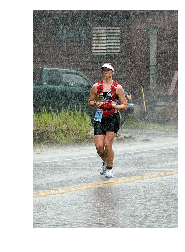

a man in a red shirt and jeans is wakeboarding on a lake


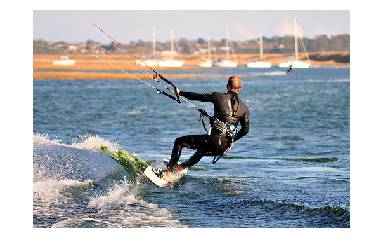

a surfer in a lake


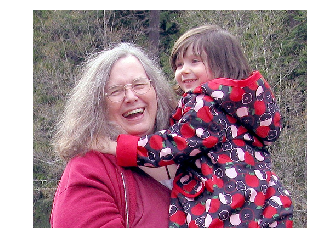

a child in a red shirt and blue jeans is lying in the grass


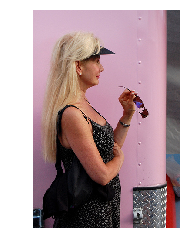

a girl in a striped shirt is standing on a


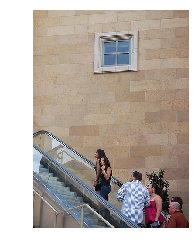

a man in a black shirt and a white shirt is standing in front of a building


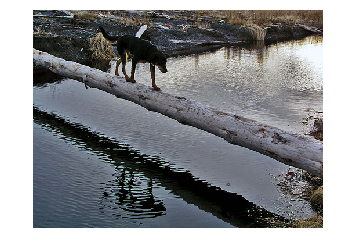

a dog is running through the water


In [48]:
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoded_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoded_test[img_name].reshape((1,2048))
    
    image = plt.imread(img_path+img_name+".jpg")
    caption = predict_caption(photo_2048)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print(caption)